In [5]:
import pandas as pd
import numpy as np
import os
import glob

In [6]:
import random

random.seed(27)

# Percent of days having power outage event


In [7]:
input_folder = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged"
data_combined = []
for filepath in glob.glob(os.path.join(input_folder, "*.csv")):
    data = pd.read_csv(filepath, encoding='latin-1', parse_dates = ['Time'])
    length =  (data['Time'].max() - data['Time'].min()).days
    filtered_data = data[data['duration']>0]
    average_duration = filtered_data['duration'].mean()
    outage_events = filtered_data.shape[0]
    percent_outage = (outage_events/length)*100
    file_name = os.path.basename(filepath)
    county = file_name.split('_')[0]
    data_combined.append({'County': county, 'Percent Outage': percent_outage, 'Outage Counts': outage_events, 'Average Duraton': average_duration})
    df = pd.DataFrame(data_combined)


In [8]:
df.head(5)

,County,Percent Outage,Outage Counts,Average Duraton
0,Alachua,31.582683,890,4.790169
1,Baker,10.007097,282,4.204787
2,Bay,34.253362,968,4.590393
3,Bradford,9.084457,256,4.308526
4,Brevard,49.148332,1385,5.219494


# Identifying weather-related power outages


In [9]:
input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged\*csv"
output_dir= r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather"
county_percentage = []
for filepath in glob.glob(input_dir):
    df = pd.read_csv(filepath, parse_dates = ['Time'])
    df.dropna(inplace = True)
    df =df.drop('region', axis =1)
    prcp95 = df['mean_prcp_mean'].quantile(0.90)
    ws95 = df['max_ws_max'].quantile(0.90)
    lis95 = df['Counts'].quantile(0.90)
    smois95 = df['smois_mean0'].quantile(0.90)
    cape95 = df['cape'].quantile(0.90)
    ds = pd.DataFrame()
    ds['Time'] =df['Time'].copy()
    ds['prcp_cat'] = df['mean_prcp_mean'].apply(lambda x: 1 if x > prcp95 else 0)
    ds['ws_cat'] = df['max_ws_max'].apply(lambda x: 1 if x > ws95 else 0)
    ds['lis_cat'] = df['Counts'].apply(lambda x: 1 if x > lis95 else 0)
    ds['smois_cat'] = df['smois_mean0'].apply(lambda x: 1 if x > smois95 else 0)
    ds['cape_cat'] = df['cape'].apply(lambda x: 1 if x > cape95 else 0)
    ds['hurdat_cat'] = df['Speed'].apply(lambda x: 1 if x > 0 else 0)
    ds['Duration'] = df['duration'].copy()
    ds['total_cust'] = df['total_cust'].copy()
    ds['cust_hour'] = df['cust_hour'].copy()
    ds['class'] = df['duration'].apply(lambda x: 1 if x > 0 else 0)
    if 'water_level' in df.columns:
        water95 = df['water_level'].quantile(0.90)
        ds['water_cat'] = df['water_level'].apply(lambda x: 1 if x > water95 else 0)

    ds['row_sum'] = ds.drop(columns=['Time', 'class', 'Duration', 'hurdat_cat', 'total_cust', 'cust_hour']).sum(axis=1)
    condition = (ds['row_sum'] >= 1) & (ds['class'] == 1)

    class_count = ds[ds['row_sum'] >=1].shape[0]
    # Count the number of times this condition is true
    if class_count > 0:
        weather_count = ds[condition].shape[0]
        total_count =ds[ds['class'] == 1].shape[0]
        weather_percentage = (weather_count/total_count) *100
    else:
        count = 0  # To avoid division by zero
        total_count =0
    


    #print(f'Percentage of event covered for {county_path} is = {count}')
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    county_percentage.append([county_path, weather_count, weather_percentage, total_count])
    county_percentage_df = pd.DataFrame(county_percentage, columns=['NAME', 'weather_outage_count', 'weather_percentage', 'total_outage_count'])

    output_path = os.path.join(output_dir, f'{county_path}_cat.csv')
    ds.to_csv(output_path, index = False)
    #print(f'saved categorized data for {county_path}')
    

# SAIDI from weather-related events

In [10]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
import os
import glob
import pandas as pd

input_directory = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather"
output_dir1 = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_ALL"

# Ensure the output directory exists
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)

saidi_values = []

def saidi_county(filepath):
    data = pd.read_csv(filepath, parse_dates=['Time'])
    
    # Weather SAIDI
    data_weather = data[data['row_sum'] > 0]
    total_cust_weather = data_weather['total_cust'].iloc[0]
    data_weather['saidi'] = (data_weather['cust_hour'] * 60) / total_cust_weather
    saidi_weather = data_weather[['Time', 'saidi']].set_index('Time')
    saidi_re_weather = saidi_weather.resample('Y').sum(numeric_only=True)
    
    # Non-Weather SAIDI
    data_nonweather = data[data['row_sum'] == 0]
    total_cust_nonweather = data_nonweather['total_cust'].iloc[0]
    data_nonweather['saidi'] = (data_nonweather['cust_hour'] * 60) / total_cust_nonweather
    saidi_nonweather = data_nonweather[['Time', 'saidi']].set_index('Time')
    saidi_re_nonweather = saidi_nonweather.resample('Y').sum(numeric_only=True)
    
    # TC SAIDI
    data_tc = data[data['hurdat_cat'] == 1]
    total_cust_tc = data_tc['total_cust'].iloc[0]
    data_tc['saidi'] = (data_tc['cust_hour'] * 60) / total_cust_tc
    saidi_tc = data_tc[['Time', 'saidi']].set_index('Time')
    saidi_re_tc = saidi_tc.resample('Y').sum(numeric_only=True)
    
    # Non-TC SAIDI
    data_nontc = data[data['hurdat_cat'] == 0]
    total_cust_nontc = data_nontc['total_cust'].iloc[0]
    data_nontc['saidi'] = (data_nontc['cust_hour'] * 60) / total_cust_nontc
    saidi_nontc = data_nontc[['Time', 'saidi']].set_index('Time')
    saidi_re_nontc = saidi_nontc.resample('Y').sum(numeric_only=True)
    
    return saidi_re_weather, saidi_re_nonweather, saidi_re_tc, saidi_re_nontc

# Process each CSV file in the directory
for filepath in glob.glob(os.path.join(input_directory, "*.csv")):
    saidi_re_weather, saidi_re_nonweather, saidi_re_tc, saidi_re_nontc = saidi_county(filepath)
    
    # Calculate averages for each SAIDI type
    avg_weather = saidi_re_weather['saidi'].mean()
    avg_nonweather = saidi_re_nonweather['saidi'].mean()
    avg_tc = saidi_re_tc['saidi'].mean()
    avg_nontc = saidi_re_nontc['saidi'].mean()
    
    # Extract county name from the filename
    county_name = os.path.basename(filepath).split('_')[0]
    
    # Append the results to saidi_values
    saidi_values.append({
        'NAME': county_name,
        'Avg_Weather_SAIDI': avg_weather,
        'Avg_NonWeather_SAIDI': avg_nonweather,
        'Avg_TC_SAIDI': avg_tc,
        'Avg_NonTC_SAIDI': avg_nontc
    })
    
    # Write processed SAIDI data to CSV in output_dir1
    combined_data = pd.concat([saidi_re_weather, saidi_re_nonweather, saidi_re_tc, saidi_re_nontc], axis=1)
    combined_data.columns = ['Weather_SAIDI', 'NonWeather_SAIDI', 'TC_SAIDI', 'NonTC_SAIDI']
    #combined_data.to_csv(os.path.join(output_dir1, os.path.basename(filepath)), index=True)
    #print(f"Processed and saved data for {os.path.basename(filepath)}")

# Convert saidi_values to a DataFrame for further processing
saidi_summary_df = pd.DataFrame(saidi_values)


In [11]:
saidi_df = pd.merge(county_percentage_df, saidi_summary_df, on = 'NAME', how = 'inner')

In [12]:
saidi_df.to_csv(r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\saidi_df.csv", index = False)

<Axes: >

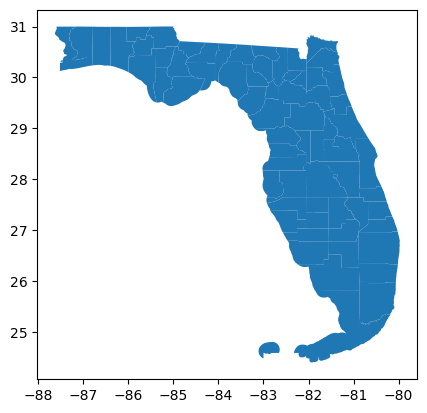

In [13]:
import geopandas as gpd
county_shp = gpd.read_file(r"F:\onedrive\OneDrive - University of Central Florida\Florida_shp\Florida_county.shp")
county_shp.plot()

In [14]:
county_combined = gpd.GeoDataFrame(pd.merge(saidi_df, county_shp, on = 'NAME', how = 'inner'), crs=county_shp.crs)

In [15]:
county_combined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67 entries, 0 to 66
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   NAME                  67 non-null     object  
 1   weather_outage_count  67 non-null     int64   
 2   weather_percentage    67 non-null     float64 
 3   total_outage_count    67 non-null     int64   
 4   Avg_Weather_SAIDI     67 non-null     float64 
 5   Avg_NonWeather_SAIDI  67 non-null     float64 
 6   Avg_TC_SAIDI          67 non-null     float64 
 7   Avg_NonTC_SAIDI       67 non-null     float64 
 8   STATEFP               67 non-null     object  
 9   COUNTYFP              67 non-null     object  
 10  COUNTYNS              67 non-null     object  
 11  GEOID                 67 non-null     object  
 12  NAMELSAD              67 non-null     object  
 13  LSAD                  67 non-null     object  
 14  CLASSFP               67 non-null     object  
 15  

In [16]:
county_combined.set_geometry('geometry', inplace = True)

In [17]:
saidi_df.columns

Index(['NAME', 'weather_outage_count', 'weather_percentage',
       'total_outage_count', 'Avg_Weather_SAIDI', 'Avg_NonWeather_SAIDI',
       'Avg_TC_SAIDI', 'Avg_NonTC_SAIDI'],
      dtype='object')

In [18]:
vmin=county_combined['Avg_Weather_SAIDI'].min()
vmax=county_combined['Avg_Weather_SAIDI'].max()
print(vmin, vmax)

223.54448894637306 7950.7710141008265


In [19]:
vmean=county_combined['Avg_Weather_SAIDI'].mean()
vmedian=county_combined['Avg_Weather_SAIDI'].median()
print(vmean, vmedian)

2431.2125987253244 1995.4060674455654


In [20]:
vmin=county_combined['weather_percentage'].min()
vmax=county_combined['weather_percentage'].max()
print(vmin, vmax)

38.91625615763547 68.48484848484848


In [21]:
county_combined.loc[county_combined['total_outage_count'].idxmax(),['NAME', 'total_outage_count']]

NAME                  Broward
total_outage_count       1524
Name: 5, dtype: object

In [22]:
county_combined.loc[county_combined['total_outage_count'].idxmin(),['NAME', 'total_outage_count']]

NAME                  Calhoun
total_outage_count        112
Name: 6, dtype: object

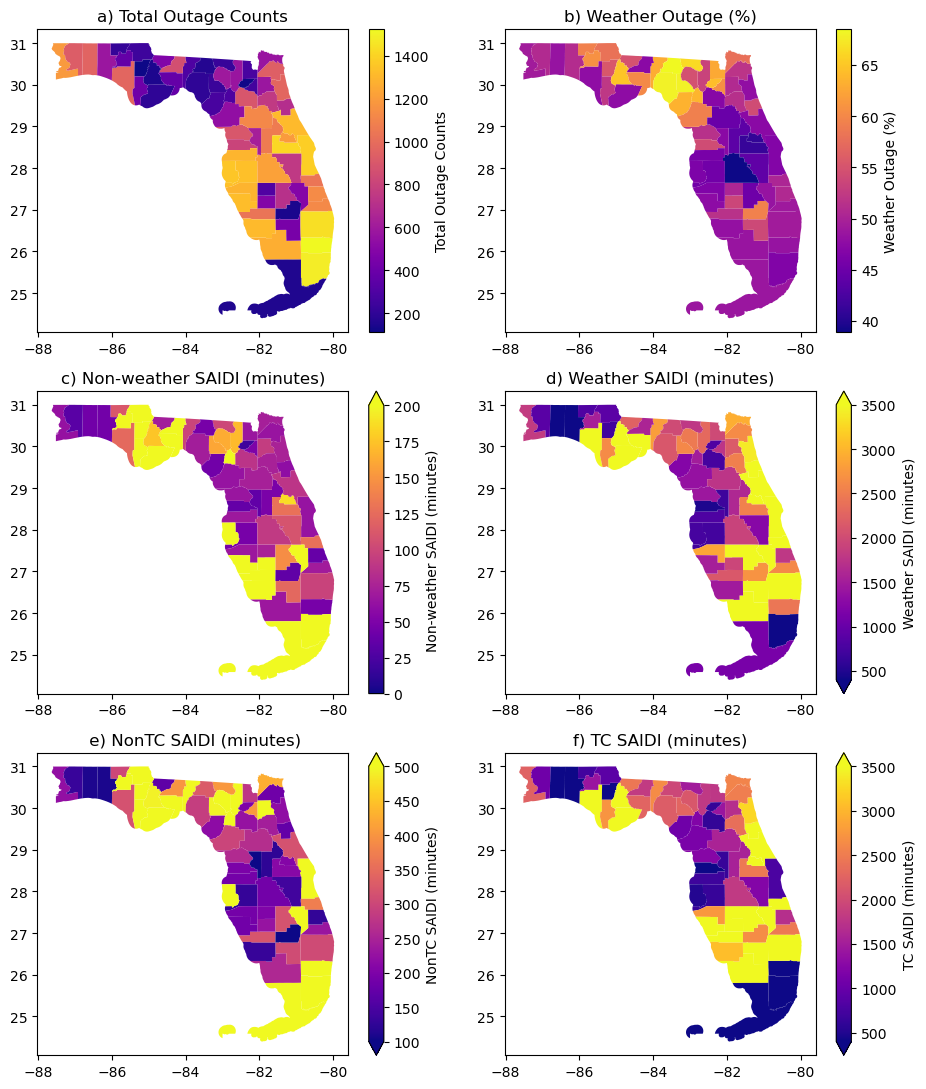

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Create a figure with 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(9.5, 11))

# Plot 1: Total Outage Counts
county_combined.plot(
    column='total_outage_count',
    cmap='plasma',
    ax=axes[0, 0],
    legend=False,
    vmin=county_combined['total_outage_count'].min(),
    vmax=county_combined['total_outage_count'].max()

)
axes[0, 0].set_title("a) Total Outage Counts")
sm1 = ScalarMappable(cmap='plasma', norm=Normalize(vmin=county_combined['total_outage_count'].min(), vmax= county_combined['total_outage_count'].max()))
sm1._A = []  # Fake data array
cbar1 = fig.colorbar(sm1, ax=axes[0, 0], extend=None)
cbar1.set_label("Total Outage Counts")

# Plot 2: Weather Outage Percentage
county_combined.plot(
    column='weather_percentage',
    cmap='plasma',
    ax=axes[0, 1],
    legend=False,
    vmin=county_combined['weather_percentage'].min(),
    vmax=county_combined['weather_percentage'].max()

)
axes[0, 1].set_title("b) Weather Outage (%)")
sm2 = ScalarMappable(cmap='plasma', norm=Normalize(vmin=county_combined['weather_percentage'].min(), vmax=county_combined['weather_percentage'].max()))
sm2._A = []
cbar2 = fig.colorbar(sm2, ax=axes[0, 1], extend=None)
cbar2.set_label("Weather Outage (%)")

# Plot 3: Non-weather SAIDI
county_combined.plot(
    column='Avg_NonWeather_SAIDI',
    cmap='plasma',
    ax=axes[1, 0],
    legend=False,
    vmin=0,
    vmax=200
)
axes[1, 0].set_title("c) Non-weather SAIDI (minutes)")
sm3 = ScalarMappable(cmap='plasma', norm=Normalize(vmin=0, vmax=200))
sm3._A = []
cbar3 = fig.colorbar(sm3, ax=axes[1, 0], extend='max')
cbar3.set_label("Non-weather SAIDI (minutes)")

# Plot 4: Weather SAIDI
county_combined.plot(
    column='Avg_Weather_SAIDI',
    cmap='plasma',
    ax=axes[1, 1],
    legend=False,
    vmin=400,
    vmax=3500
)
axes[1, 1].set_title("d) Weather SAIDI (minutes)")
sm4 = ScalarMappable(cmap='plasma', norm=Normalize(vmin=400, vmax=3500))
sm4._A = []
cbar4 = fig.colorbar(sm4, ax=axes[1, 1], extend='both')
cbar4.set_label("Weather SAIDI (minutes)")

# Plot 5: NonTC SAIDI
county_combined.plot(
    column='Avg_NonTC_SAIDI',
    cmap='plasma',
    ax=axes[2, 0],
    legend=False,
    vmin=100,
    vmax=500
)
axes[2, 0].set_title(" e) NonTC SAIDI (minutes)")
sm5 = ScalarMappable(cmap='plasma', norm=Normalize(vmin=100, vmax=500))
sm5._A = []
cbar5 = fig.colorbar(sm5, ax=axes[2, 0], extend='both')
cbar5.set_label("NonTC SAIDI (minutes)")

# Plot 6: TC SAIDI
county_combined.plot(
    column='Avg_TC_SAIDI',
    cmap='plasma',
    ax=axes[2, 1],
    legend=False,
    vmin=400,
    vmax=3500
)
axes[2, 1].set_title("f) TC SAIDI (minutes)")
sm6 = ScalarMappable(cmap='plasma', norm=Normalize(vmin=400, vmax=3500))
sm6._A = []
cbar6 = fig.colorbar(sm6, ax=axes[2, 1], extend='both')
cbar6.set_label("TC SAIDI (minutes)")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# Percent Overlap

In [24]:
import os
import glob
import pandas as pd
import numpy as np

input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\*csv"
output_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\categorized_data"
os.makedirs(output_dir, exist_ok=True)

uni_duration = []
for filepath in glob.glob(input_dir):
    ds = pd.read_csv(filepath, parse_dates=['Time'])
    
    # Total count of rows where 'class' equals 1
    total_count = ds[(ds['class'] == 1) & (ds['row_sum'] >= 1)].shape[0]
    
    # Define a function to dynamically determine columns to sum
    def get_sum_columns(ds, exclude_columns):
        return [col for col in ['prcp_cat', 'ws_cat', 'lis_cat', 'smois_cat', 'cape_cat', 'water_cat'] if col in ds.columns and col not in exclude_columns]

    # Calculate durations
    mean_prcp_duration = ((ds[(ds['prcp_cat'] == 1) & 
                              (ds['class'] == 1) & 
                              (ds[get_sum_columns(ds, ['prcp_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_ws_duration = ((ds[(ds['ws_cat'] == 1) & 
                            (ds['class'] == 1) & 
                            (ds[get_sum_columns(ds, ['ws_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_lis_duration = ((ds[(ds['lis_cat'] == 1) & 
                             (ds['class'] == 1) & 
                             (ds[get_sum_columns(ds, ['lis_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_smois_duration = ((ds[(ds['smois_cat'] == 1) & 
                               (ds['class'] == 1) & 
                               (ds[get_sum_columns(ds, ['smois_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100

    mean_cape_duration = ((ds[(ds['cape_cat'] == 1) & 
                              (ds['class'] == 1) & 
                              (ds[get_sum_columns(ds, ['cape_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100


    # Check if 'water_cat' exists in the DataFrame
    if 'water_cat' in ds.columns:
        mean_wl_duration = ((ds[(ds['water_cat'] == 1) & 
                                (ds['class'] == 1) & 
                                (ds[get_sum_columns(ds, ['water_cat'])].sum(axis=1) == 0)]['class'].count()) / total_count) * 100
    else:
        # Set mean_wl_duration to NaN if 'water_cat' is not available
        mean_wl_duration = np.nan

    # Save results for the current file
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    uni_duration.append([
        county_path, mean_prcp_duration, mean_ws_duration, mean_lis_duration, 
        mean_smois_duration, mean_cape_duration, mean_wl_duration
    ])

# Convert results to a DataFrame
uni_df = pd.DataFrame(uni_duration, columns=['NAME', 'Prcp', 'WS', 'LIS', 'SMOIS', 'CAPE', 'WL'])

# Uncomment to save the DataFrame to CSV if needed
# output_path = os.path.join(output_dir, 'categorized_data_summary.csv')
# uni_df.to_csv(output_path, index=False)

# Print success message
# print("Data processing complete. Summary saved to output directory.")


In [25]:
uni_df_com = gpd.GeoDataFrame(pd.merge(county_shp, uni_df, on = 'NAME', how = 'inner'), crs = county_shp.crs)
uni_df_com.set_geometry('geometry', inplace = True)

In [26]:
uni_df.describe()

,Prcp,WS,LIS,SMOIS,CAPE,WL
count,67.000000,67.000000,67.000000,67.000000,67.000000,35.000000
mean,2.878211,8.078761,12.766977,4.045256,9.287770,10.647261
std,1.462232,2.624439,2.724218,1.776254,2.712209,2.697671
min,0.000000,2.150538,3.529412,0.000000,1.351351,4.301075
25%,1.930945,6.193781,10.810415,2.946281,7.879819,8.988722
50%,2.725724,7.823129,12.653061,3.804348,9.558824,11.323764
75%,3.821335,9.971980,14.205004,5.304048,11.220837,12.870810
max,8.552632,14.473684,19.469027,8.108108,14.117647,14.821124


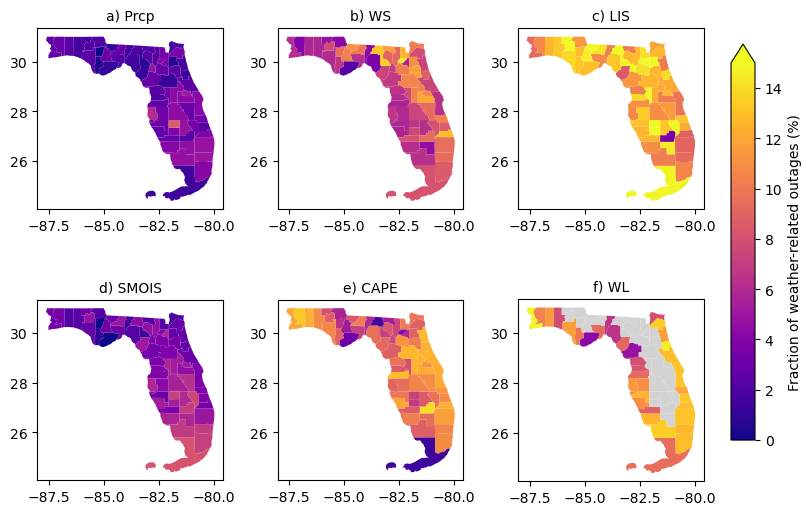

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon

n_col = 3
n_row = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(8, 6))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 0
vmax = 15
axes = axes.flatten()
column_list = ['Prcp', 'WS', 'LIS', 'SMOIS', 'CAPE', 'WL']

for i, name in enumerate(column_list):
    # Construct the column name
    column_name = name

    if column_name == 'WL':  # Handle WL column separately for NaN values
        uni_df_com.plot(
            ax=axes[i],
            column=f'{column_name}',
            legend=True,
            cax=cax,
            cmap='plasma',
            vmin=vmin,
            vmax=vmax,
            missing_kwds={"color": "lightgray", "label": "No Data"}
        )
    else:
        # Plot other columns without specific handling for NaN
        uni_df_com.plot(
            ax=axes[i],
            column=f'{column_name}',
            legend=True,
            cax=cax,
            cmap='plasma',
            vmin=vmin,
            vmax=vmax
        )

    # Add subplot title with numbering
    axes[i].set_title(f'{chr(97 + i)}) {column_name}', fontsize=10)

# Hide any empty subplots
for j in range(len(column_list), len(axes)):
    axes[j].axis('off')

# Add colorbar with label
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    cax=cax,
    extend='max'
)
cbar.set_label('Fraction of weather-related outages (%)')


# Adjust layout to prevent overlapping and cropping
plt.tight_layout(rect=[0, 0, 0.92, 0.93])

plt.show()


In [28]:
import os
import glob
import pandas as pd
import numpy as np

input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\*csv"
output_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\categorized_data"
os.makedirs(output_dir, exist_ok=True)

compound_duration = []

for filepath in glob.glob(input_dir):
    ds = pd.read_csv(filepath, parse_dates=['Time'])
    
    # Calculate total count for the relevant rows
    total_count = ds[(ds['class'] == 1) & (ds['row_sum'] >= 1)].shape[0]
    
    # Handle cases where total_count is zero to avoid division by zero
    if total_count == 0:
        total_count = np.nan  # Assign NaN for rows where no valid data is present
    
    # Function to dynamically determine columns for summation
    def get_sum_columns(ds, exclude_columns):
        base_columns = ['prcp_cat', 'ws_cat', 'lis_cat', 'smois_cat', 'cape_cat']
        if 'water_cat' in ds.columns:
            base_columns.append('water_cat')
        return [col for col in base_columns if col in ds.columns and col not in exclude_columns]
    
    # Calculate percentages for each combination
    prcp_lis = ((ds[(ds['prcp_cat'] == 1) & (ds['lis_cat'] == 1) & (ds['class'] == 1) &
                    (ds[get_sum_columns(ds, ['prcp_cat', 'lis_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
        
    prcp_ws = ((ds[(ds['prcp_cat'] == 1) & (ds['ws_cat'] == 1) & (ds['class'] == 1) &
                   (ds[get_sum_columns(ds, ['prcp_cat', 'ws_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100

    prcp_smois = ((ds[(ds['prcp_cat'] == 1) & (ds['smois_cat'] == 1) &
                       (ds['class'] == 1) & 
                       (ds[get_sum_columns(ds, ['prcp_cat', 'smois_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    ws_smois = ((ds[(ds['ws_cat'] == 1) & (ds['smois_cat'] == 1) &
                     (ds['class'] == 1) & 
                     (ds[get_sum_columns(ds, ['ws_cat', 'smois_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    ws_lis = ((ds[(ds['ws_cat'] == 1) & (ds['lis_cat'] == 1) &
                   (ds['class'] == 1) & 
                   (ds[get_sum_columns(ds, ['ws_cat', 'lis_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    lis_smois = ((ds[(ds['smois_cat'] == 1) & (ds['lis_cat'] == 1) &
                      (ds['class'] == 1) & 
                      (ds[get_sum_columns(ds, ['smois_cat', 'lis_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
   
    two_plus = ((ds[(ds['row_sum'] >= 2) & (ds['class'] == 1)]['Duration'].count()) / total_count) * 100
    
    if 'water_cat' in ds.columns:
        prcp_wl = ((ds[(ds['prcp_cat'] == 1) & (ds['water_cat'] == 1) &
                        (ds['class'] == 1) & 
                        (ds[get_sum_columns(ds, ['prcp_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
       
        ws_wl = ((ds[(ds['ws_cat'] == 1) & (ds['water_cat'] == 1) &
                      (ds['class'] == 1) & 
                      (ds[get_sum_columns(ds, ['ws_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
        
        lis_wl = ((ds[(ds['lis_cat'] == 1) & (ds['water_cat'] == 1) &
                       (ds['class'] == 1) & 
                       (ds[get_sum_columns(ds, ['lis_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
        
        smois_wl = ((ds[(ds['smois_cat'] == 1) & (ds['water_cat'] == 1) &
                         (ds['class'] == 1) & 
                         (ds[get_sum_columns(ds, ['smois_cat', 'water_cat'])].sum(axis=1) == 0)]['Duration'].count()) / total_count) * 100
    
    else:
        # Set means to NaN if 'water_cat' is not available
        prcp_wl = np.nan
        ws_wl = np.nan
        lis_wl = np.nan
        smois_wl = np.nan
        
    # Save results for the current file
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    compound_duration.append([county_path, prcp_lis, prcp_ws, prcp_smois, prcp_wl, ws_smois, ws_wl, ws_lis, lis_smois, lis_wl, smois_wl, two_plus])

# Convert results to a DataFrame
compound_df = pd.DataFrame(compound_duration, columns=['NAME', 'prcp_lis', 'prcp_ws', 'prcp_smois', 'prcp_wl', 'ws_smois', 'ws_wl', 'ws_lis', 'lis_smois', 'lis_wl', 'smois_wl', 'two_plus'])


In [29]:
compound_df['two_plus'].max()

76.34408602150538

In [30]:
compound_df.describe()

,prcp_lis,prcp_ws,prcp_smois,prcp_wl,ws_smois,ws_wl,ws_lis,lis_smois,lis_wl,smois_wl,two_plus
count,67.000000,67.000000,67.000000,35.000000,67.000000,35.000000,67.000000,67.000000,35.000000,35.000000,67.000000
mean,1.238093,1.744848,7.437477,0.590146,1.159482,1.771799,4.246127,0.812573,0.806862,0.896694,57.381022
std,0.689206,0.985598,2.961949,0.428160,0.747127,1.359420,2.025650,0.743927,0.652060,0.798730,6.654320
min,0.000000,0.000000,2.631579,0.000000,0.000000,0.000000,1.075269,0.000000,0.000000,0.000000,45.735027
25%,0.869631,1.212422,5.187947,0.367383,0.716404,0.632395,2.833234,0.314724,0.433527,0.359517,52.741170
50%,1.200000,1.687764,6.954887,0.505902,1.075269,1.515152,4.052098,0.680272,0.637959,0.674536,57.881773
75%,1.534715,2.105496,9.701932,0.813749,1.471861,2.455162,5.663377,1.126104,0.877345,1.135137,61.088643
max,3.947368,5.882353,13.713080,2.150538,3.968254,4.388715,10.619469,3.529412,3.225806,2.702703,76.344086


In [31]:
compound_df_com = gpd.GeoDataFrame(pd.merge(county_shp, compound_df, on = 'NAME', how = 'inner'), crs = county_shp.crs)
compound_df_com.set_geometry('geometry', inplace = True)

In [46]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon
n_col = 4
n_row =3
fig, axes = plt.subplots(n_row, n_col, figsize = (9, 7))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 0
vmax = 6
axes = axes.flatten()
column_list = ['prcp_lis', 'prcp_ws', 'prcp_smois', 'ws_smois', 'ws_lis', 'lis_smois', 'prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
coastal_column = ['prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
for i, name in enumerate(column_list):
    # Construct the column name with the '_SAIDI' suffix
    column_name = name
    for i, name in enumerate(column_list):
    # Construct the column name
        column_name = name
        
        if column_name in coastal_column:  # Handle WL column separately for NaN values
            # Plot with gray color for NaN values in the 'WL' column
            compound_df_com.plot(
                ax=axes[i],
                column=f'{column_name}',
                legend=True,
                cax=cax,
                cmap='plasma',
                vmin=vmin,
                vmax=vmax,
                edgecolor = 'white',
                missing_kwds={"color": "lightgray", "label": "No Data"}
            )

        else:
            # Plot other columns without specific handling for NaN
        # Plot each column in a separate subplot with consistent color limits
            compound_df_com.plot(ax=axes[i], column=f'{column_name}', legend=True, cax=cax, cmap='plasma', vmin=vmin, vmax=vmax)
        axes[i].set_title(f'{chr(97 + i)}) {column_name}', fontsize=10)
# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add colorbar with label
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cax , extend = 'max')
cbar.set_label('Fraction of eather-related outage %')


# Set the title for the entire plot and adjust its position
#plt.suptitle('Average Duration for different Univariate events', y=0.90)

# Adjust layout to remove space after the title and prevent cropping
#plt.tight_layout(rect=[0, 0, 0.92, 0.95])


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000016B1BE8B4C0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
n_col = 4
n_row =3
fig, axes = plt.subplots(n_row, n_col, figsize = (9, 7))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 0
vmax = 6
axes = axes.flatten()
column_list = ['prcp_lis', 'prcp_ws', 'prcp_smois', 'ws_smois', 'ws_lis', 'lis_smois', 'prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
coastal_column = ['prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
for i, name in enumerate(column_list):
    # Construct the column name with the '_SAIDI' suffix
    column_name = name
    for i, name in enumerate(column_list):
    # Construct the column name
        column_name = name
        
        if column_name in coastal_column:  # Handle WL column separately for NaN values
            # Plot with gray color for NaN values in the 'WL' column
            compound_df_com.plot(
                ax=axes[i],
                column=f'{column_name}',
                legend=True,
                cax=cax,
                cmap='plasma',
                vmin=vmin,
                vmax=vmax,
                missing_kwds={"color": "lightgray", "label": "No Data"},
                edgecolor = 'white',
                linewidth = 0.08
            )

        else:
            # Plot other columns without specific handling for NaN
        # Plot each column in a separate subplot with consistent color limits
            compound_df_com.plot(
                ax=axes[i], 
                column=f'{column_name}', 
                legend=True, 
                cax=cax, 
                cmap='plasma', 
                vmin=vmin, 
                vmax=vmax,
                edgecolor = 'white',
                linewidth = 0.08
            )
        axes[i].set_title(f'{chr(97 + i)}) {column_name}', fontsize=10)
# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add colorbar with label
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cax , extend = 'max')
cbar.set_label('Fraction of weather-related outage (%)')


# Adjust layout to remove space after the title and prevent cropping
#plt.tight_layout(rect=[0, 0, 0.92, 0.95])

# Univariate events characteristics

In [33]:
import os
import glob
import pandas as pd
import numpy as np

input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\*csv"
output_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\categorized_data"
os.makedirs(output_dir, exist_ok=True)

uni_duration = []

for filepath in glob.glob(input_dir):
    ds = pd.read_csv(filepath, parse_dates=['Time'])
    
    # Function to dynamically determine columns for summation
    def get_sum_columns(ds, exclude_columns):
        base_columns = ['prcp_cat', 'ws_cat', 'lis_cat', 'smois_cat', 'cape_cat']
        if 'water_cat' in ds.columns:
            base_columns.append('water_cat')
        return [col for col in base_columns if col in ds.columns and col not in exclude_columns]

    # Calculate medians for each category
    mean_prcp_duration = ds[
        (ds['prcp_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['prcp_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    mean_ws_duration = ds[
        (ds['ws_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['ws_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    mean_lis_duration = ds[
        (ds['lis_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['lis_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    mean_smois_duration = ds[
        (ds['smois_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['smois_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    mean_cape_duration = ds[
        (ds['cape_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['cape_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    if 'water_cat' in ds.columns:
        mean_wl_duration = ds[
            (ds['water_cat'] == 1) & 
            (ds['class'] == 1) & 
            (ds[get_sum_columns(ds, ['water_cat'])].sum(axis=1) == 0)
        ]['Duration'].median()
    else:
        # Assign NaN if 'water_cat' is not available
        mean_wl_duration = np.nan

    # Extract county name from the file path
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    
    # Append results to the list
    uni_duration.append([
        county_path, 
        mean_prcp_duration, 
        mean_ws_duration, 
        mean_lis_duration, 
        mean_smois_duration, 
        mean_cape_duration, 
        mean_wl_duration
    ])

# Convert results to a DataFrame
uni_df_duration = pd.DataFrame(
    uni_duration, 
    columns=['NAME', 'Prcp', 'WS', 'LIS', 'SMOIS', 'CAPE', 'WL']
)



In [34]:
uni_df_durcom = gpd.GeoDataFrame(pd.merge(county_shp, uni_df_duration, on = 'NAME', how = 'inner'), crs = county_shp.crs)

In [35]:
uni_df_durcom.set_geometry('geometry', inplace = True)

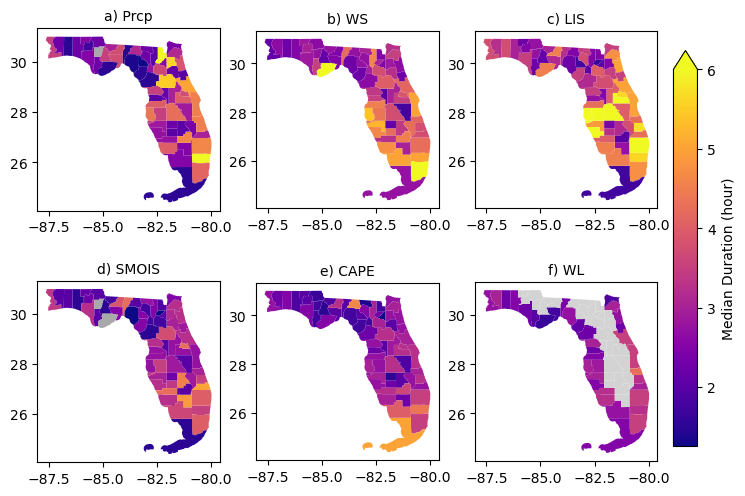

In [36]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon

n_col = 3
n_row = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(8, 6))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 1.25
vmax = 6
axes = axes.flatten()
column_list = ['Prcp', 'WS', 'LIS', 'SMOIS', 'CAPE', 'WL']

for i, name in enumerate(column_list):
    # Construct the column name
    column_name = name
    
    if column_name == 'WL':  # Handle WL column separately for NaN values
        # Plot with gray color for NaN values in the 'WL' column
        uni_df_durcom.plot(
            ax=axes[i],
            column=f'{column_name}',
            legend=True,
            cax=cax,
            cmap='plasma',
            vmin=vmin,
            vmax=vmax,
            missing_kwds={"color": "lightgray", "label": "No Data"}
        )
    else:
        # Plot other columns without specific handling for NaN
        uni_df_durcom.plot(
            ax=axes[i],
            column=f'{column_name}',
            legend=True,
            cax=cax,
            cmap='plasma',
            vmin=vmin,
            vmax=vmax,
            missing_kwds={"color": "darkgray", "label": "No Data"}
        )

    axes[i].set_title(f'{chr(97 + i)}) {column_name}', fontsize=10)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(hspace=0.2)

# Add colorbar with label
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    cax=cax,
    extend='max'
)
cbar.set_label('Median Duration (hour)')

# Show the plot
plt.show()


# Bivariate events characteristics

In [37]:
import os
import glob
import pandas as pd
import numpy as np

input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\*csv"
output_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\categorized_data"
os.makedirs(output_dir, exist_ok=True)

compound_duration = []

for filepath in glob.glob(input_dir):
    ds = pd.read_csv(filepath, parse_dates=['Time'])
    
    # Function to dynamically determine columns for summation
    def get_sum_columns(ds, exclude_columns):
        base_columns = ['prcp_cat', 'ws_cat', 'lis_cat', 'smois_cat', 'water_cat']
        return [col for col in base_columns if col in ds.columns and col not in exclude_columns]

    # Calculate medians for pairwise combinations
    prcp_lis = ds[
        (ds['prcp_cat'] == 1) & 
        (ds['lis_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['prcp_cat', 'lis_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
        
    prcp_ws = ds[
        (ds['prcp_cat'] == 1) & 
        (ds['ws_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['prcp_cat', 'ws_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()

    prcp_smois = ds[
        (ds['prcp_cat'] == 1) & 
        (ds['smois_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['prcp_cat', 'smois_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    ws_smois = ds[
        (ds['ws_cat'] == 1) & 
        (ds['smois_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['ws_cat', 'smois_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    ws_lis = ds[
        (ds['ws_cat'] == 1) & 
        (ds['lis_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['ws_cat', 'lis_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    lis_smois = ds[
        (ds['smois_cat'] == 1) & 
        (ds['lis_cat'] == 1) & 
        (ds['class'] == 1) & 
        (ds[get_sum_columns(ds, ['lis_cat', 'smois_cat'])].sum(axis=1) == 0)
    ]['Duration'].median()
    
    if 'water_cat' in ds.columns:
        prcp_wl = ds[
            (ds['prcp_cat'] == 1) & 
            (ds['water_cat'] == 1) & 
            (ds['class'] == 1) & 
            (ds[get_sum_columns(ds, ['prcp_cat', 'water_cat'])].sum(axis=1) == 0)
        ]['Duration'].median()
       
        ws_wl = ds[
            (ds['ws_cat'] == 1) & 
            (ds['water_cat'] == 1) & 
            (ds['class'] == 1) & 
            (ds[get_sum_columns(ds, ['ws_cat', 'water_cat'])].sum(axis=1) == 0)
        ]['Duration'].median()
        
        lis_wl = ds[
            (ds['lis_cat'] == 1) & 
            (ds['water_cat'] == 1) & 
            (ds['class'] == 1) & 
            (ds[get_sum_columns(ds, ['lis_cat', 'water_cat'])].sum(axis=1) == 0)
        ]['Duration'].median()
        
        smois_wl = ds[
            (ds['smois_cat'] == 1) & 
            (ds['water_cat'] == 1) & 
            (ds['class'] == 1) & 
            (ds[get_sum_columns(ds, ['smois_cat', 'water_cat'])].sum(axis=1) == 0)
        ]['Duration'].median()
    else:
        # Set medians to NaN if 'water_cat' is not available
        prcp_wl = np.nan
        ws_wl = np.nan
        lis_wl = np.nan
        smois_wl = np.nan
        
    # Extract county name from the file path
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    
    # Append results to the list
    compound_duration.append([
        county_path, prcp_lis, prcp_ws, prcp_smois, prcp_wl, 
        ws_smois, ws_wl, ws_lis, lis_smois, lis_wl, smois_wl
    ])

# Convert results to a DataFrame
compound_df_duration = pd.DataFrame(
    compound_duration, 
    columns=['NAME', 'prcp_lis', 'prcp_ws', 'prcp_smois', 'prcp_wl', 
             'ws_smois', 'ws_wl', 'ws_lis', 'lis_smois', 'lis_wl', 'smois_wl']
)

# Save the results to the output directory
#output_path = os.path.join(output_dir, 'compound_duration_summary.csv')
#compound_df.to_csv(output_path, index=False)

# Print success message
print("Data processing complete. Summary saved to:", output_path)


Data processing complete. Summary saved to: F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\Washington_cat.csv


In [38]:
compound_df_merged = pd.merge(county_shp, compound_df_duration, on = 'NAME', how = 'inner')
compound_df_merged = compound_df_merged.set_geometry('geometry')

<Axes: >

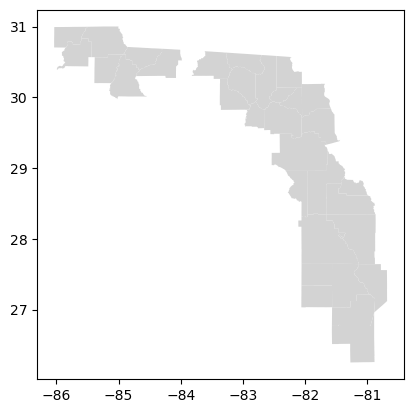

In [39]:
rows_with_nan = uni_df_com[pd.isna(uni_df_com['WL'])]
rows_with_nan.plot(color = 'lightgray')

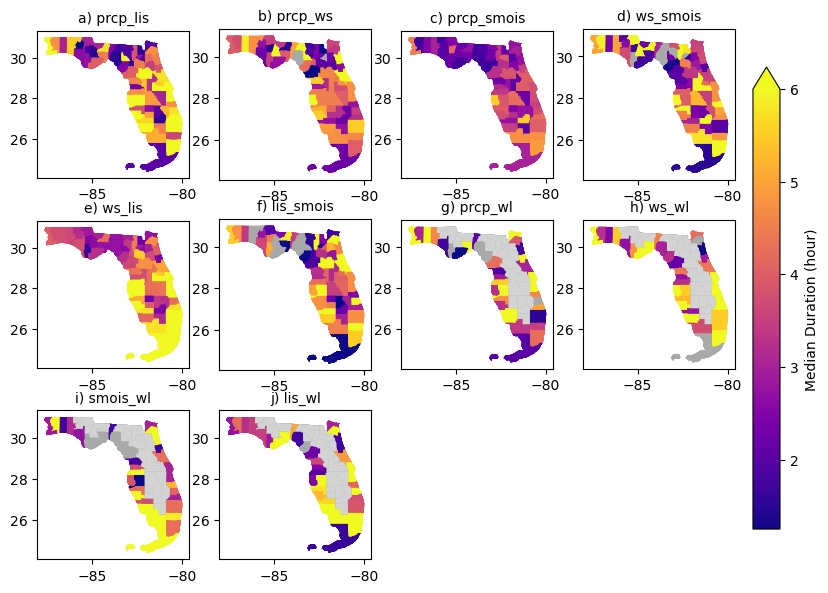

In [40]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon
n_col = 4
n_row =3
fig, axes = plt.subplots(n_row, n_col, figsize = (9, 7))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 1.25
vmax = 6
axes = axes.flatten()
column_list = ['prcp_lis', 'prcp_ws', 'prcp_smois', 'ws_smois', 'ws_lis', 'lis_smois', 'prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
coastal_column = ['prcp_wl', 'ws_wl', 'smois_wl', 'lis_wl']
for i, name in enumerate(column_list):
    # Construct the column name with the '_SAIDI' suffix
    column_name = name
    for i, name in enumerate(column_list):
    # Construct the column name
        column_name = name
        
        if column_name in coastal_column:  # Handle WL column separately for NaN values
            # Plot with gray color for NaN values in the 'WL' column
            compound_df_merged.plot(
                ax=axes[i],
                column=f'{column_name}',
                legend=True,
                cax=cax,
                cmap='plasma',
                vmin=vmin,
                vmax=vmax,
                missing_kwds={"color": "darkgray", "label": "No Data"}
            )
            rows_with_nan.plot(color = 'lightgray', ax=axes[i])

        else:
            # Plot other columns without specific handling for NaN
        # Plot each column in a separate subplot with consistent color limits
            compound_df_merged.plot(ax=axes[i], column=f'{column_name}', legend=True, cax=cax, cmap='plasma', vmin=vmin, vmax=vmax,
            missing_kwds={"color": "darkgray", "label": "No Data"})
        axes[i].set_title(f'{chr(97 + i)}) {column_name}', fontsize=10)
# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add colorbar with label
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cax , extend = 'max')
cbar.set_label('Median Duration (hour)')


# Characteristics of different combinations of events

In [41]:
import os
import glob
import pandas as pd
import numpy as np

input_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\SAIDI_merged_weather\*csv"
output_dir = r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\categorized_data"
os.makedirs(output_dir, exist_ok=True)

comb_duration = []

for filepath in glob.glob(input_dir):
    ds = pd.read_csv(filepath, parse_dates=['Time'])

    # Calculate medians for each category
    single_duration = ds[
        (ds['row_sum'] == 1) & (ds['class'] ==1)]['Duration'].median()
    
    double_duration = ds[
        (ds['row_sum'] == 2) & (ds['class'] ==1)]['Duration'].median()
    
    triple_duration = ds[
        (ds['row_sum'] == 3) & (ds['class'] ==1)]['Duration'].median()
    
    triple_plus_duration = ds[
        (ds['row_sum'] > 3) & (ds['class'] ==1)]['Duration'].median()
    
    mean_weather_duration = ds[
        (ds['row_sum'] >= 1) & 
        (ds['class'] == 1)]['Duration'].median()
    
    mean_nonweather_duration = ds[
        (ds['row_sum'] == 0) & 
        (ds['class'] == 1) & (ds['hurdat_cat'] ==0)]['Duration'].median()  

    # Extract county name from the file path
    base_name = os.path.basename(filepath)
    county_path = base_name.split('_')[0]
    
    # Append results to the list
    comb_duration.append([
        county_path, 
        single_duration, 
        double_duration, 
        triple_duration, 
        triple_plus_duration, 
        mean_weather_duration, 
        mean_nonweather_duration
    ])

# Convert results to a DataFrame
comb_df_duration = pd.DataFrame(
    comb_duration, 
    columns=['NAME', 'Single', 'Double', 'Triple', 'Triple+', 'Median Weather', 'Median Nonweather']
)



In [42]:
comb_df_duration.describe()

,Single,Double,Triple,Triple+,Median Weather,Median Nonweather
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,2.945896,3.432836,3.847015,4.513060,3.328358,2.406716
std,0.700454,1.038175,1.230688,1.671272,0.845508,0.421006
min,1.750000,2.250000,2.000000,1.750000,2.250000,1.750000
25%,2.312500,2.687500,3.000000,3.187500,2.500000,2.000000
50%,2.875000,3.000000,3.500000,4.125000,3.125000,2.500000
75%,3.500000,4.187500,4.687500,5.562500,4.000000,2.750000
max,4.500000,5.750000,7.375000,8.250000,5.000000,3.250000


In [43]:
comb_merged = gpd.GeoDataFrame(pd.merge(county_shp, comb_df_duration, on = 'NAME', how = 'inner'), crs = county_shp.crs)

In [44]:
comb_merged.set_geometry('geometry', inplace = True)

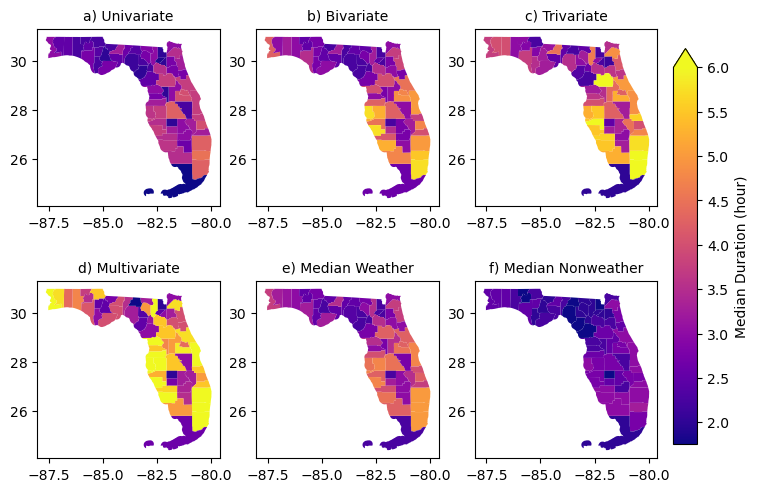

In [45]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon

n_col = 3
n_row = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(8, 6))
cax = fig.add_axes([0.92, 0.16, 0.03, 0.66])
vmin = 1.75
vmax = 6
axes = axes.flatten()

# Define names for titles and columns
name_list = ['Univariate', 'Bivariate', 'Trivariate', 'Multivariate', 'Median Weather', 'Median Nonweather']
column_list = ['Single', 'Double', 'Triple', 'Triple+', 'Median Weather', 'Median Nonweather']

for i, (column_name, title_name) in enumerate(zip(column_list, name_list)):  # Pair values from both lists
    # Plot each column in a separate subplot with consistent color limits
    comb_merged.plot(ax=axes[i], column=f'{column_name}', legend=True, cax=cax, cmap='plasma', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'{chr(97 + i)}) {title_name}', fontsize=10)  # Use name_list for titles

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(hspace=0.2)

# Add colorbar with label
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cax, extend='max')
cbar.set_label('Median Duration (hour)')

# plt.savefig(r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\univariate.png", dpi=300, bbox_inches='tight')

# plt.suptitle('Average Duration for different Univariate events', y=0.90)  # Set title for entire figure if needed
plt.show()
